<a href="https://colab.research.google.com/github/tsubasa05/Poker-Stats-Machine-learning/blob/main/poker_stats_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#ライブラリーのインポート、初期設定
import os
import numpy as np
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(7)
rn.seed(7)

session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
#ドライブからデータを持ってくる
df = pd.read_csv('/content/drive/My Drive/sample all.csv')
alldata = pd.read_csv('/content/drive/My Drive/allhand all.csv')

In [5]:
#必要のないコラムを削除
df.drop(['Source.Name','Total Hands','bb/100','All-in Adj bb/100'], axis=1,inplace=True)

In [6]:
#かぶりのある行の排除
for i in range(0,len(df)-1,3):
  df.drop(index=[i+1],inplace=True)
  df.drop(index=[i+2],inplace=True)

In [7]:
#かぶりのある行の排除
for i in range(0,len(alldata)-1,3):
  alldata.drop(index=[i+1],inplace=True)
  alldata.drop(index=[i+2],inplace=True)

In [8]:
#3-5
#alldataをプレイヤー名と成績のみのリストに変える
N1 = alldata.loc[:,'All-in Adj bb/100']
N2 = alldata.loc[:,'Player']

alldata2 = pd.concat([N1, N2],axis=1)

In [9]:
#3-6
#ラベルとプレイヤーの統計を結合する
df['label']=0
for i in range(0,len(df)-1,1):
  for k in range(0,len(alldata2)-1,1):
    if alldata2.iat[k,1] == df.iat[i,0]:
      if alldata2.iat[k,0] >= 3.72:
        df.iat[i,len(df.columns)-1]=1

In [10]:
#3-7
#player名の列を削除
df.drop(['Player'], axis=1,inplace=True)

In [11]:
#1-4,3-8
#欠測地の数を調べる
s = df.isnull().sum()
#これはseries型。データフレームに変換するし、転置
k = pd.DataFrame(s).T
#データフレーム型に変える必要はない。series型をそのまま追加。
df.loc['欠測地'] = s

In [12]:
#1-5,3-9
#欠測地順にソート
df.sort_values(by='欠測地', axis=1, ascending=True, inplace=True)

In [13]:
#1-6,3-10
#欠測地が10以上の列を削除
for i in df.columns.values:
  if df.at['欠測地',i]>10:
    df.drop(columns=i,inplace=True)

In [14]:
#1-7,3-11
#欠測地の排除
df.drop(index=['欠測地'],inplace=True)

In [15]:
#特徴量と教師に分ける
#教師データ
Y = df.loc[:,'label'].values
#特徴量データから教師データを削除
df.drop(columns='label',inplace=True)


#特徴量データの作成
X = df.loc[:,:].values

**学習の特徴量として使用する統計はサンプル数が100以上集まったものを利用する**

In [16]:
#学習に利用する統計のみ特徴量として抽出する
X = df.loc[:,['VPIP','Limp','PFR','Cold Call','3bet In Position','3bet Out of Position','Fold to 3Bet IP','Fold to 3Bet OOP','4Bet IP','4Bet OOP','Fold to 4Bet','5Bet (Raise 4Bet)','WTSD%','W$WSF','W$SD%','Agg','River Call Efficiency','Flop CBet IP%','Flop CBet OOP%','Flop Fold vs Cbet OOP','Flop Raise Cbet OOP','Flop Fold vs Cbet IP','Flop Raise Cbet IP','Bet Turn OOP vs Missed Flop CBet OOP','Turn CBet IP%','Turn CBet OOP%','Bet Flop vs Missed CBet','Fold Turn IP Skip CBet','Delayed Turn CBet% OOP','Check Fold Flop% As PFR','Check Raise Flop% As PFR','Delayed Turn CBet% IP','Turn Fold vs Cbet OOP','Bet River OOP vs Missed Turn CBet OOP','Turn Fold vs Cbet IP','Skip Turn CB and Fold To River Bet IP','Check Fold Turn OOP Skip CBet','Check Raise Turn OOP Skip CBet','Bet Turn IP vs Missed CBet','Flop CBet-Fold IP TOT','Flop CBet-Fold OOP TOT','River CBet OOP%','River CBet IP%']].values

In [23]:
#欠測地の補完
from sklearn.impute import SimpleImputer

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(X)
X = imr.transform(X)

In [26]:
#3-13
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=0)

In [27]:
#データの標準化
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test -= mean
X_test /= std

# モデルの選択および学習

In [28]:
#ニューラルネットワークによる分類モデル
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(50, activation='relu',
                           input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1,activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [33]:
#4分割交差検証
k = 4
num_val_samples = len(X_train) // k
num_epochs = 1000
all_scores = []
all_acc_histories = []
all_val_acc_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,batch_size=1, verbose=0)
    
    acc_history = history.history['acc']
    val_acc_history = history.history['val_acc']
    all_acc_histories.append(acc_history)
    all_val_acc_histories.append(val_acc_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


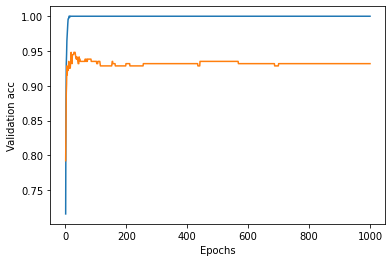

acc: 1.0 val_acc: 0.9318181872367859


In [37]:
#モデルの訓練用データ、検証用データの正解率
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]

average_val_acc_history = [
    np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.plot(range(1, len(average_val_acc_history) + 1), average_val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()
print('acc:',average_acc_history[num_epochs-1],'val_acc:',average_val_acc_history[num_epochs-1])

In [35]:
#テストデータによる評価
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)
print(test_mse_score,test_mae_score)

5/5 [==============================] - 0s 3ms/step - loss: 0.6136 - acc: 0.9398
0.6135825514793396 0.9398496150970459
